# Kinetics II

This Notebook continues with the analysis of kinetic data obtained in a constant volume batch reactor. It considers the same data set from [Notebook 39](), where we applied a differential method of analysis to estimate the reaction order and rate constant for an $A \rightarrow B$ reaction. In this Notebook, we will work through the same data set using an integral method of analysis. We will also reinforce concepts in linear regression and assessing goodness of fit using basic statistical analysis.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01

```{note}
This problem statement is the same as [Example Problem 01 in Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html#example-problem-01), but we will apply a new method of analysis.
```
The following reaction is carried out in a well-mixed, isothermal, constant volume batch reactor. The concentration of species $A$ and $B$ in the tank are initially $C_{A0} = 10 \mathrm{M}$ and $C_{B0} = 0 \mathrm{M}$ at $t = 0$. You may assume that the fluid inside of the reactor has constant density. 
			
$$A \longrightarrow B$$
			
We measure the concentration of species $A$ in this reactor, monitoring how it changes with time. The collected data are tabulated below. 

| time (s) | $C_A \ (\mathrm{mol \ L^{-1}})$ |  time (s)  | $C_A \ (\mathrm{mol \ L^{-1}})$ |
|:--------:|:-------------------------------:|:----------:|:-------------------------------:|
|0         | 10.0                            | 34         | 4.96                            |
|1         | 9.58                            | 55         | 4.10                            |
|2         | 9.21                            | 89         | 3.33                            |
|3         | 8.87                            | 144        | 2.68                            |
|5         | 8.30                            | 233        | 2.13                            | 
|8         | 7.62                            | 377        | 1.69                            |
|13        | 6.79                            | 610        | 1.34                            |
|21        | 5.88                            | 987        | 1.06                            |

You may assume that the rate law for this reaction follows basic, power law kinetics, i.e.:
 
$$r = k{C_A}^{\alpha}$$

where $\alpha$ is a presently unknown integer. Use the data in the above table to determine the reaction order, $\alpha$, and to estimate the rate constant, $k$, as precisely as possible.

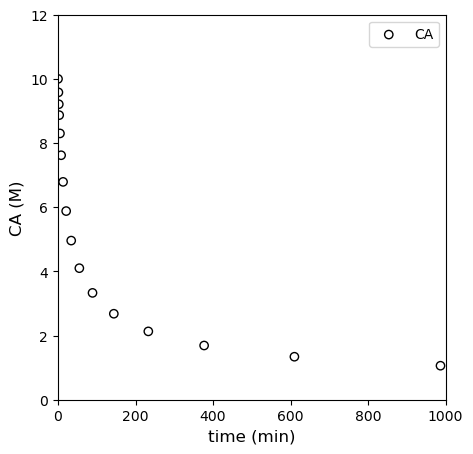

In [5]:
###################################################################################################
# Store experimental time and concentration data in separate arrays                               #
###################################################################################################

tdata  = np.array([0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987]) #time in seconds
CAdata = np.array([10.00, 9.58, 9.21, 8.87, 8.30, 7.62, 6.79, 5.88, 4.96, 4.10, 3.33, 2.68, 2.13, 1.69, 1.34, 1.06])# Concentrations in moles per liter

###################################################################################################
# Graph experimental CA vs t data                                                                 #
###################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

### Solution to Example Problem 01

We want to use the data to determine the rate law and kinetic parameters $(\alpha, k)$. This is an inverse problem, and we need to find a way to extract this information from the data. Since this reaction is overall (not an elementary step), we can at most propose that the rate of reaction depends on temperature (which we capture with a rate constant) and the concentration of the reactant, $A$. At the moment, the reaction order is unknown, and propose general power law kinetics with an unknown reaction order $\alpha$.

$$r = k{C_A}^\alpha$$

As discussed in [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html), the data available is a set of values for $C_A$ measured at various values of $t$. We do not yet have a model that could describe the functional relationship between $C_A$ and $t$, we only have a proposed rate law that describes the general relationship between $r$ and $C_A$. In order to model the dependence of $C_A$ on $t$, we need to solve a material balance on this batch reactor -- it may not be immediately intuitive, but we make this choice because, fundamentally, the material balance is what specifies the relationship between $C_A$ and $t$, it just does so in the form of a differential equation. We start by writing a material balance on species $A$ in this constant volume batch reactor:

$$\frac{dN_A}{dt} = R_AV$$

For a constant volume reactor, we can divide through by $V$ and move it inside of the derivative:

$$\frac{dC_A}{dt} = R_A$$

For a single reaction, we know that $R_A = -r$, so:

$$\frac{dC_A}{dt} = -r$$

Finally, we have proposed power law kinetics, hence:

$$\frac{dC_A}{dt} = -k{C_A}^\alpha$$

At this point, we make a decision about whether we want to use a ***differential*** method of analysis, where we attempt to approximate reaction rates by taking numerical derivatives of data, or an ***integral*** method of analysis, where we attempt to solve the material balance by integration and then regress parameters in the resultant model that best describe our data.  

In [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html), we used a differential method of analysis. Some points about differential analysis should be clear after working through Notebook 39.

**Advantages of Differential Analysis***

1. Quick to apply using finite differences
2. Convenient when you do not know the reaction order as it will be determined by regression
3. Avoids having to guess reaction orders and solve the material balance as with integral methods

**Challenges with Differential Analysis**

1. Numerical differentiation is imprecise, and especially so when considering large changes in concentration/time
2. Imprecision arises from the assumption that the derivative is constant over the range considered, a built in feature of finite differences
3. If we aren't careful, a differential analysis can give us a false impression of true reaction kinetics, even for "perfect data" generated by a batch reactor simulation.

Today, we'll consider the integral method of analysis and highlight its strengths and weaknesses.  We'll also take this opportunity to introduce nonlinear regression, which is a very useful skill.

### Integral Analysis

As the name suggests, integral analysis of batch reactor data is based on integration, which entails solving the differential equation that comprises the batch reactor material balance.  Above, we developed the following ODE that describes the change in the concentration of species a with respect to time -- remember that at this point this is done symbolically for an arbitrary rate constant, $k$, and an arbitrary reaction order $\alpha$. As of now, we do not know either of their values, so we leave them symbolic in the material balance.

$$\frac{dC_A}{dt} = -k{C_A}^\alpha$$

Now, we proceed with solving the material balance. The easiest way to do this is to guess a numerical value for the reaction order, which permits a straightforward analysical solution. Once we have an analytical solution for an assumed reaction order, we can check to see if the data are well described by that solution. If so, then we would conclude that the proposed reaction order is probably adequate. If not, we would conclude that the proposed reaction order does not describe the data, and we would repeat the procedure with a different numerical value of reaction order. Although iterating through reaction orders is somewhat tedious, it gives us a lot of information, and it has an added bonus of providing us the opportunity to compare goodness of fit across multiple models. Often, it is difficult to determine in isolation if a single model fits data well -- one can improve confidence by comparing optimal fits for many models, which is helpful in identifing the model that best describes the data.

Let's start simple by assuming (1) that the reaction order is positive and (2) that the reaction has an integer order in $A$. With this in mind, a good starting point would be to say that the reaction order is either order is either 1, 2, or 3. Once we do that, we can solve the material balance on $A$ for each reaction order to get three different analytical solutions for $C_A(t)$. We can then compare each to our data.

#### First Order Solution

For a first order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -kC_A$$

This is a separable ODE, so we'll solve it by hand.

```note
It is far better in kinetic analysis if you can obtain an analytical solution than having to resort to a numerical one.
```

$$\int_{C_{A0}}^{C_A}\frac{1}{C_A}dC_A = \int_0^t-kdt$$

Which gives:

$$C_A = C_{A0}\exp\left(-kt\right)$$

#### Second Order Solution

For a second order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k{C_A}^2$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^2}dC_A = \int_0^t-kdt$$

Which gives:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$$

And, keeping with the theme of solving for $C_A(t)$, we can rearrange to get:

$$C_A = \left(\frac{1}{C_{A0}} + kt\right)^{-1}$$

#### Third Order Solution

For a third order reaction, the material balance on A in a constant volume reactor becomes:

$$\frac{dC_A}{dt} = -k{C_A}^3$$

This is a separable ODE, so we'll solve it by hand.

$$\int_{C_{A0}}^{C_A}\frac{1}{{C_A}^3}dC_A = \int_0^t-kdt$$

Which gives:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A0}}^2} + kt$$

And, keeping with the theme of solving for $C_A(t)$, we can rearrange to get:

$$C_A = \left(\frac{1}{{C_{A0}}^2} + 2kt\right)^{-\frac{1}{2}}$$

Now, we are ready to decide which of these models (if any!) describes our data the best. To summarize, we have 3 models to vet against our data:

**First Order**: $C_A = C_{A0}\exp\left(-kt\right)$

**Second Order**: $C_A = \left(\frac{1}{C_{A0}} + kt\right)^{-1}$

**Third Order**: $C_A = \left(\frac{1}{{C_{A0}}^2} + 2kt\right)^{-\frac{1}{2}}$

We're going to make this comparison in two ways.  First, we will overlay these models directly with our data, which is a plot of concentration vs. time.  Then we'll vary the value of the unknown parameter (k) until we get the best fit for the data. We'll start with a very crude manual approach to get a feel for how this works, we will consider how we can do a better job of quantifying the error between measurement values and model predictions, and then we will look at more sophisticated strategies for minimizing that error.

First, a manual approach with only visual feedback about quality of fit.

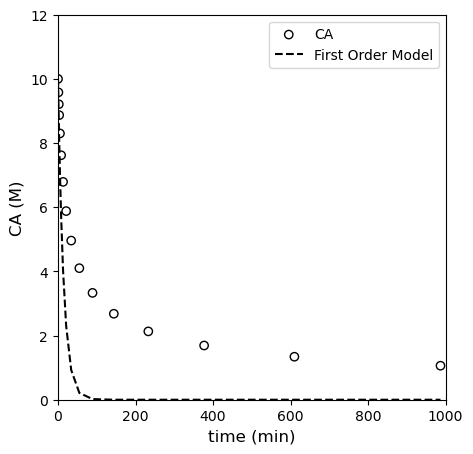

In [87]:
##Testing first order model
CAONE = lambda k, t: CA0*np.exp(-k*t)
CA0   = 10 #mol/L
ktest = 0.07  #mol/L/min

#Pass test rate constant to a 1st order model to generate line of best fit for plot
CMODONE = CAONE(ktest, tdata)

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tdata, CMODONE, color = 'black', linestyle = 'dashed', label = 'First Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

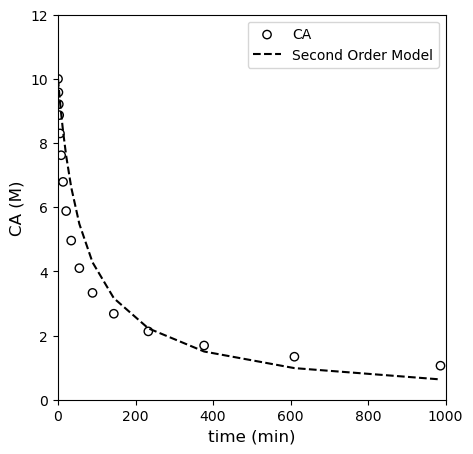

In [85]:
##Testing second order model
CATWO = lambda k, t: 1/(1/CA0 + k*t)
CA0   = 10 #mol/L
ktest = 0.0015  #mol/L/min

#Pass test rate constant to a 2nd order model to generate line of best fit for plot
CMODTWO = CATWO(ktest, tdata)

plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tdata, CMODTWO, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

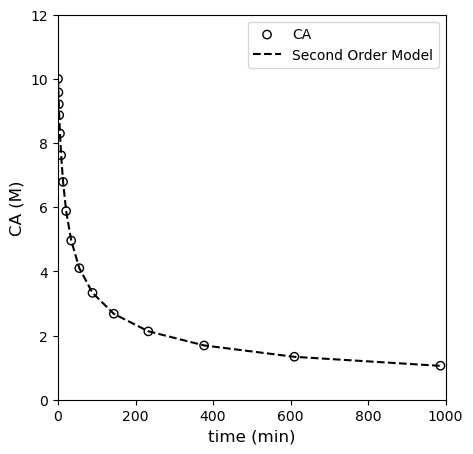

In [22]:
##Testing third order model
CATHREE = lambda k, t: np.sqrt(1/(1/CA0**2 + 2*k*t))
CA0     = 10 #mol/L
ktest   = 0.00045  #mol/L/min

#Pass test rate constant to a 3rd order model to generate line of best fit for plot
CMODTHREE = CATHREE(ktest, tdata)

plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tdata, CMODTHREE, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

The mathematically rigorous way to find the best value of the rate constant is to find the one that gives the "line of best fit."  That is to say, the best model/rate constant is the one that ***minimizes*** the total error between model predictions and measurement values.

In all of the above, the systems are very overdetermined.  We have 18 data points, and, in each of our models (zero order, first order, and second order), there is only a single unknown (k).  So there won't be a unique solution in any of these cases.  Instead, we find the solution that minimizes the error between our model prediction, which is the heart of regression analysis.

There are many ways to perform a regresion, and you have lots of choices about the nature of the objective function that you're trying to minimize.  Here, we'll keep it simple and do the most common type, which is least-squares regression. Specifically, we will quantify the total error in our system as the sum of square differences between model predictions and measurement values:  

$$SSE = \sum_i \left(\bar{y}_i - \hat{y}_i\right)^2$$

Here, $\bar{y}_i$ is the $i^\text{th}$ measurement of the observable $y$ at the corresponding value of independent variable, $x_i$, and $\hat{y}$ is the model prediction of the observable value ($y$) at the same condition of independent variable, $x_i$. The quantity in parentheses represents the displacement (or "error") between our model's prediction and our measurement's value.  We square it to ensure that the error is positive -- otherwise, positive and negative errors will average out to zero, making it difficult to identify the true minimum error.

In this case, we'd base our SSE on measured and model predicted values of the concentration of A since that is our observable.

$$SSE = \sum_i \left(\bar{C}_{A_i} - \hat{C}_{A_i}\right)^2$$

Now that we have a lot of experience writing functions to accomplish all sorts of things, it is relatively straightforward to write a function to calculate the sum of squares for a given model at a certain value of rate constant.  We can then look at both the plot *and* the more quantitative sum of square errors for the current parameter value.

In [73]:
def OBJONE(k):
    CA0     = 10 #mol/L
    tdata   = np.array([0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987])#, 1597, 4181, 6765, 10946]) #time in seconds
    CAdata  = np.array([10.00, 9.58, 9.21, 8.87, 8.30, 7.62, 6.79, 5.88, 4.96, 4.10, 3.33, 2.68, 2.13, 1.69, 1.34, 1.06])#, 0.8312, 0.5148, 0.4049, 0.3184]) 
    CAmodel = CAONE(k, tdata)
    RESID   = CAdata - CAmodel
    SSE     = np.sum(RESID**2)
    print(f'k = {k:9.2E}, SSE = {SSE:7.2E}')
    # plt.figure(figsize = (5, 5))
    # plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
    # plt.plot(tdata, CAmodel, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
    # plt.xlabel('time (min)', fontsize = 12)
    # plt.ylabel('CA (M)', fontsize = 12)
    # plt.xlim(0, 1000)
    # plt.ylim(0, 12)
    # plt.legend()
    # plt.show()
    return SSE

In [69]:
OBJONE(0.0021)

k =  2.10E-03, SSE = 1.47E+02


146.6370097467223

#### Minimizing the error with numerical tools

It is of course better to use numerical methods to find the value of the parameter that minimizes our objective function (SSE).  We use the exact same approach for minimizing the SSE as we've been using for things like yield and reactor volume. Generally speaking, we do this with `opt.minimize_scalar()` for univariate problems and `opt.minimize()` for multivariate problems.

We'll consider the zero order model first:

In [74]:
#Run Optimization
ans_one = opt.minimize_scalar(OBJONE)#, method = 'Brent', bracket = [0.01, 10])

k =  0.00E+00, SSE = 4.82E+02
k =  1.00E+00, SSE = 4.43E+02
k =  2.62E+00, SSE = 5.18E+02
k =  1.62E+00, SSE = 4.90E+02
k =  6.18E-01, SSE = 3.80E+02
k =  3.82E-01, SSE = 3.08E+02
k =  2.36E-01, SSE = 2.36E+02
k =  1.46E-01, SSE = 1.69E+02
k =  9.02E-02, SSE = 1.12E+02
k =  5.57E-02, SSE = 6.70E+01
k =  3.44E-02, SSE = 3.68E+01
k =  2.13E-02, SSE = 2.17E+01
k =  1.32E-02, SSE = 2.19E+01
k =  1.74E-02, SSE = 2.00E+01
k =  1.73E-02, SSE = 2.00E+01
k =  1.67E-02, SSE = 1.99E+01
k =  1.53E-02, SSE = 2.02E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01


k =  0.00E+00, SSE = 4.82E+02
k =  1.00E+00, SSE = 4.43E+02
k =  2.62E+00, SSE = 5.18E+02
k =  1.62E+00, SSE = 4.90E+02
k =  6.18E-01, SSE = 3.80E+02
k =  3.82E-01, SSE = 3.08E+02
k =  2.36E-01, SSE = 2.36E+02
k =  1.46E-01, SSE = 1.69E+02
k =  9.02E-02, SSE = 1.12E+02
k =  5.57E-02, SSE = 6.70E+01
k =  3.44E-02, SSE = 3.68E+01
k =  2.13E-02, SSE = 2.17E+01
k =  1.32E-02, SSE = 2.19E+01
k =  1.74E-02, SSE = 2.00E+01
k =  1.73E-02, SSE = 2.00E+01
k =  1.67E-02, SSE = 1.99E+01
k =  1.53E-02, SSE = 2.02E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01
k =  1.68E-02, SSE = 1.99E+01

k =  1.68E-02, SSE = 1.99E+01


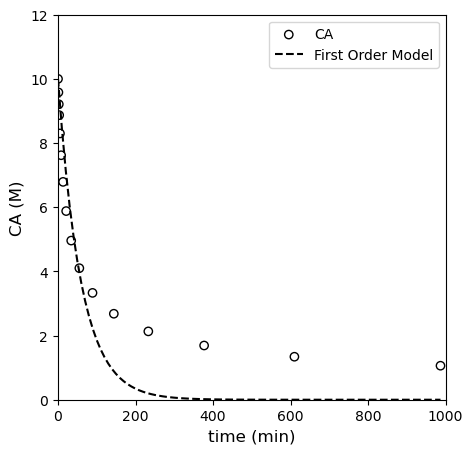

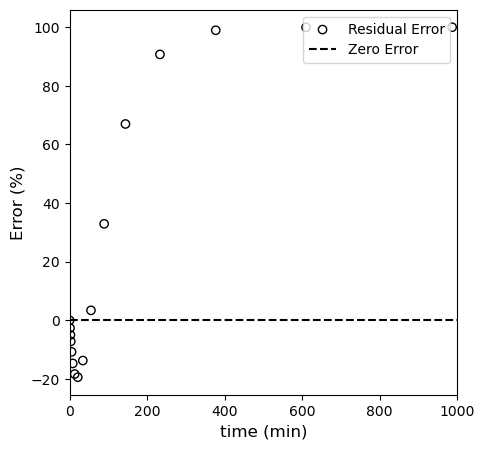

In [81]:
#Run Optimization
ans_one = opt.minimize_scalar(OBJONE)#, method = 'Brent', bracket = [0.01, 10])
SSE     = ans_one.fun
k_one   = ans_one.x
print(f'\nk = {k_one:9.2E}, SSE = {SSE:7.2E}')

#Pass optimum rate constant to a 1st order model to generate line of best fit for plot
tsmooth = np.linspace(0, max(tdata), 100)
CA0     = 10 #mol/L
CMODONE = CAONE(k_one, tsmooth) #CA0*np.exp(-k_one*tsmooth)

#Overlay best fit model with data
plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tsmooth, CMODONE, color = 'black', linestyle = 'dashed', label = 'First Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

#Create plot of residuals
plt.figure(figsize = (5, 5))
plt.scatter(tdata, (CAdata - CAONE(k_one, tdata))/CAdata*100, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 1000, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Error (%)', fontsize = 12)
plt.xlim(0, 1000)
# plt.ylim(-1, 1)
plt.legend(loc = 'upper right')
plt.show()

#### Analysis of First Order Fit

Based on that result, the best fit value of the rate constant in a zero order model is 0.017, which achieves a minimum SSE of ~19.9.  Visually, it does an OK job of fitting data at low times, but it falls apart after about 100 minutes.  We notice that the first order model over-predicts measured concentration at short times, and it underpredicts at long times.  This would be a sign that the order of reaction is too low.

Now we'll do the same optimization with a second order model.

#### Second order optimization

In [82]:
def OBJTWO(k):
    CA0     = 10 #mol/L
    tdata   = np.array([0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987])#, 1597, 4181, 6765, 10946]) #time in seconds
    CAdata  = np.array([10.00, 9.58, 9.21, 8.87, 8.30, 7.62, 6.79, 5.88, 4.96, 4.10, 3.33, 2.68, 2.13, 1.69, 1.34, 1.06])#, 0.8312, 0.5148, 0.4049, 0.3184])
    CAmodel = CATWO(k, tdata)
    RESID   = CAdata - CAmodel
    SSE     = np.sum(RESID**2)
    print(f'k = {k:9.2E}, SSE = {SSE:7.2E}')
    return SSE

k =  0.00E+00, SSE = 4.82E+02
k =  1.00E+00, SSE = 4.95E+02
k = -1.62E+00, SSE = 5.60E+02
k = -6.18E-01, SSE = 6.13E+02
k =  3.82E-01, SSE = 4.46E+02
k =  6.00E-01, SSE = 4.73E+02
k =  3.21E-01, SSE = 4.33E+02
k =  1.98E-01, SSE = 3.90E+02
k =  1.22E-01, SSE = 3.37E+02
k =  7.57E-02, SSE = 2.78E+02
k =  4.68E-02, SSE = 2.17E+02
k =  2.89E-02, SSE = 1.57E+02
k =  1.79E-02, SSE = 1.04E+02
k =  1.10E-02, SSE = 6.05E+01
k =  6.82E-03, SSE = 2.86E+01
k =  4.22E-03, SSE = 9.76E+00
k =  2.61E-03, SSE = 4.49E+00
k =  1.67E-03, SSE = 1.17E+01
k =  3.03E-03, SSE = 4.67E+00
k =  2.73E-03, SSE = 4.40E+00
k =  2.76E-03, SSE = 4.40E+00
k =  2.75E-03, SSE = 4.40E+00
k =  2.76E-03, SSE = 4.40E+00
k =  2.76E-03, SSE = 4.40E+00
k =  2.76E-03, SSE = 4.40E+00
k =  2.76E-03, SSE = 4.40E+00
k =  2.76E-03, SSE = 4.40E+00

k =  2.76E-03, SSE = 4.40E+00


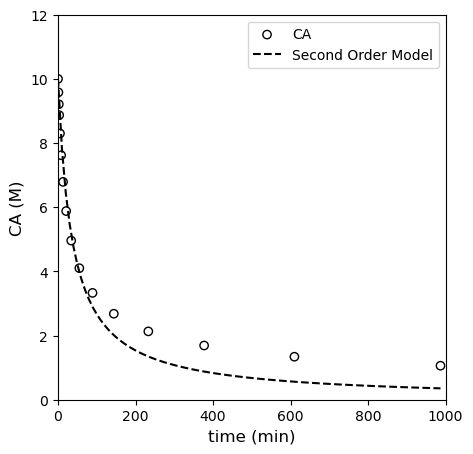

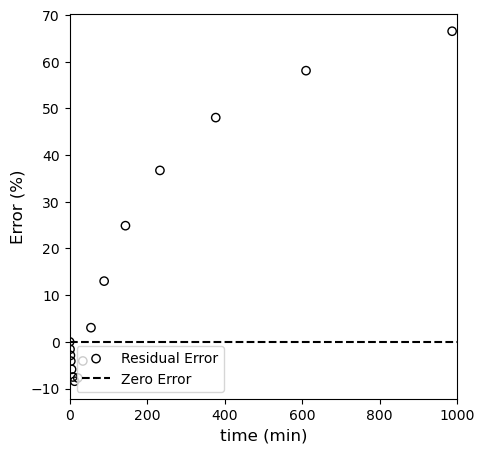

In [83]:
#Run Optimization
ans_two = opt.minimize_scalar(OBJTWO)#, method = 'Brent', bracket = [0.01, 10])
SSE     = ans_two.fun
k_two   = ans_two.x
print(f'\nk = {k_two:9.2E}, SSE = {SSE:7.2E}')

#Pass optimum rate constant to a 2nd order model to generate line of best fit for plot
tsmooth = np.linspace(0, max(tdata), 100)
CA0     = 10 #mol/L
CMODTWO = CATWO(k_two, tsmooth) #CA0*np.exp(-k_one*tsmooth)

#Overlay best fit model with data
plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tsmooth, CMODTWO, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

#Create plot of residuals
plt.figure(figsize = (5, 5))
plt.scatter(tdata, (CAdata - CATWO(k_two, tdata))/CAdata*100, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 1000, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Error (%)', fontsize = 12)
plt.xlim(0, 1000)
# plt.ylim(-1000, 1000)
plt.legend(loc = 'lower left')
plt.show()

#### Analysis of 2nd order fit

This does a better job than the first order model; we find that an optimum rate constant of 0.0028 L/mol/min gives us a minimum sum of squares of 4.40, which is quite a bit better than the minimum sum of squares achieved with a first order model (19.9).  Still, the shape of the curve is not quite correct, and we find that the model overpredicts concentrations at short times and under predicts them at longer times.  This would prompt me to try a 3rd order model...

#### Optimization of a 3rd order model

In [84]:
def OBJTHREE(k):
    CA0     = 10 #mol/L
    tdata   = np.array([0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987])#, 1597, 4181, 6765, 10946]) #time in seconds
    CAdata  = np.array([10.00, 9.58, 9.21, 8.87, 8.30, 7.62, 6.79, 5.88, 4.96, 4.10, 3.33, 2.68, 2.13, 1.69, 1.34, 1.06])#, 0.8312, 0.5148, 0.4049, 0.3184])
    CAmodel = CATHREE(k, tdata)
    RESID   = CAdata - CAmodel
    SSE     = np.sum(RESID**2)
    print(f'k = {k:9.2E}, SSE = {SSE:7.2E}')
    return SSE

k =  3.82E-01, SSE = 4.61E+02
k =  6.18E-01, SSE = 4.75E+02
k =  2.36E-01, SSE = 4.42E+02
k =  1.46E-01, SSE = 4.19E+02
k =  9.02E-02, SSE = 3.92E+02
k =  5.57E-02, SSE = 3.59E+02
k =  3.45E-02, SSE = 3.21E+02
k =  2.13E-02, SSE = 2.77E+02
k =  1.32E-02, SSE = 2.30E+02
k =  8.14E-03, SSE = 1.81E+02
k =  5.03E-03, SSE = 1.33E+02
k =  3.12E-03, SSE = 8.89E+01
k =  1.93E-03, SSE = 5.19E+01
k =  1.20E-03, SSE = 2.39E+01
k =  7.43E-04, SSE = 6.34E+00
k =  4.63E-04, SSE = 2.00E-02
k =  2.90E-04, SSE = 4.89E+00
k =  5.02E-04, SSE = 3.02E-01
k =  4.60E-04, SSE = 1.10E-02
k =  4.49E-04, SSE = 4.06E-04
k =  3.88E-04, SSE = 5.58E-01
k =  4.52E-04, SSE = 5.86E-04
k =  4.46E-04, SSE = 3.03E-03

k =  4.49E-04, SSE = 4.06E-04


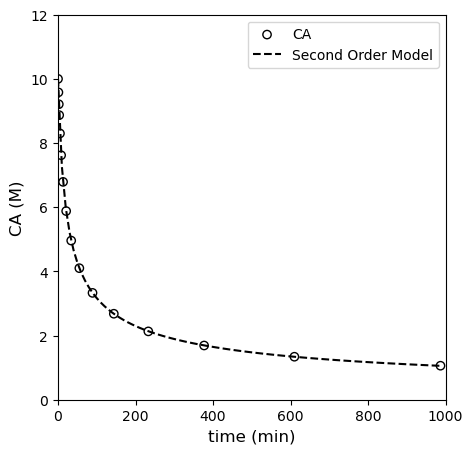

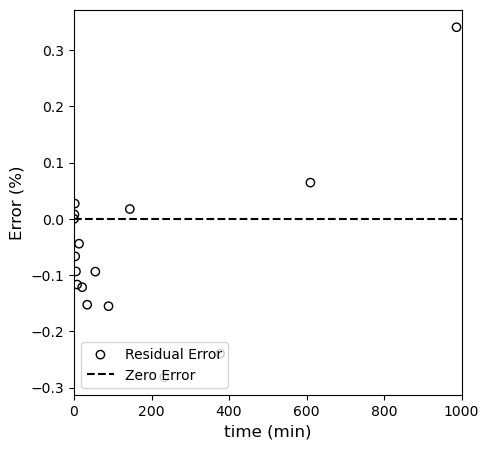

In [80]:
#Run Optimization
ans_three = opt.minimize_scalar(OBJTHREE, method = 'Bounded', bounds = [0.00001, 1])
SSE       = ans_three.fun
k_three   = ans_three.x
print(f'\nk = {k_three:9.2E}, SSE = {SSE:7.2E}')

#Pass optimum rate constant to a third order model to generate line of best fit for plot
tsmooth   = np.linspace(0, max(tdata), 100)
CA0       = 10 #mol/L
CMODTHREE = CATHREE(k_three, tsmooth) #CA0*np.exp(-k_one*tsmooth)

#Overlay best fit model with data
plt.figure(figsize = (5, 5))
plt.scatter(tdata, CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.plot(tsmooth, CMODTHREE, color = 'black', linestyle = 'dashed', label = 'Second Order Model')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

#Create plot of residuals
plt.figure(figsize = (5, 5))
plt.scatter(tdata, (CAdata - CATHREE(k_three, tdata))/CAdata*100, edgecolor = 'black', color = 'none', label = 'Residual Error')
plt.hlines(0, 0, 1000, color = 'black', linestyle = 'dashed', label = 'Zero Error')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Error (%)', fontsize = 12)
plt.xlim(0, 1000)
# plt.ylim(-1000, 1000)
plt.legend(loc = 'lower left')
plt.show()

Now we have a great fit to the data.  This is indicated visually in the line of best fit and the residual plots, where we observe scatter around the liner of zero error. We also see this quantitatively in the minimum SSE of 4.06E-04, which is orders of magnitude smaller than the minimum SSE for first and second order models. Based on this, we would conclude that this reaction is third order in the concentration of A, and we would report that $k \approx 4.5 \times 10^{-04} \ \mathrm{L^2 \ mol^{-2} \ min^{-1}}$.


Thus far, we've used "nonlinear" regression because the models that we fit for first, second, and third order kinetics were non-linear functions of time.  This is a powerful technique but it can also lead to problems. Most notably, when have data that is nonlinear, it is supposed to be curved in some way.  It can be hard to tell if the amount of curvature is correct.  In this case, it is easy to see, but recall that this is actually a perfect data set that I generated by solving a first order system.  When we have messy, "real" data, it can be difficult to tell if the type of curvature observed in your model is correct, and it can be hard to resolve whether one nonlinear model is better than the other.

Where it is possible to do so, it is always useful to linearize a model.  This gains us a couple of important things.

1. Whereas deviation between experimental data and a curved line can be difficult to assess, it is relatively easy to detect deviations from linearity.  This makes linearization a powerful visual tool for assessing goodness of fit.
2. If we can linearize a model, we can use linear regression tools.  Regardless of how they are packaged (e.g., trendline in Excel or polyfit in Python), they are all based on similar methods that use linear algebra.  
3. They key here is that linear regression solutions are deterministic.  There **is** a unique solution for the parameters that give us the best fit if we use linear regression. 
4. With nonlinear regression (as above), we are forced to use interative optimization routines like `opt.minimize()` or `opt.minimize_scalar()`, which are not necessarily guaranteed to converge.  The linear algebra solutions will be much more stable, which can be very beneficial in difficult optimization problems.

For these reasons, we'll consider how to linearize these models, perform linear regressions, and visually inspect the results compared to a linearized data set.

### Linearized Models

**First Order Model**

For the first order model, we have:

$$C_A = C_{A0}\exp(-kt)$$

This is a nonlinear function of $t$; however, if we take the natural logarithm of both sides, we convert it to the following, which useful:

$$\ln\left(C_A\right) = \ln\left(C_{A0}\right) - kt$$

If we plot $\ln{(C_A)}$ against time, that should be linear if the first order model is correct.  The slope would be equal to $-k$, and the y-intercept would be $\ln{(CA0)}$.  In the matrix form:

$$\alpha_1t^1 + \alpha_0t^0 = \ln\left(C_A\right)$$

We can put this into the vandermonde form:

$$XA = Y$$

Where X is the vandermonde matrix generated from our time data  (and truncated to include only zero order and first order terms), and Y is the natural log of CA.

This is plotted in the cell below, where you clearly observe a deviation from linearity.

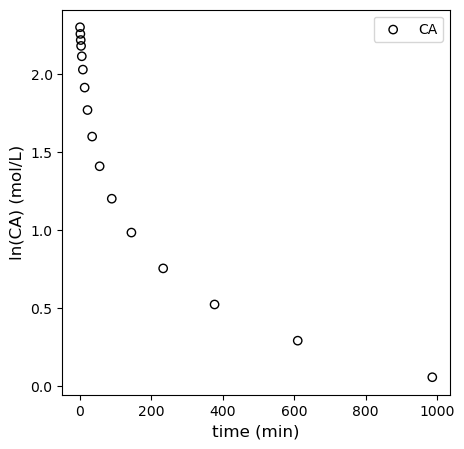

In [89]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, np.log(CAdata), edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('ln(CA) (mol/L)', fontsize = 12)
# plt.xlim(0, 120)
# plt.ylim(0, 12)
plt.legend()
plt.show()

Now that we've visually assessed linearity, we proceed with regression analysis and return the various parameter estimates and statistics.

[-0.00234601  1.85560255] 

m    = -2.35E-03 +/-  7.78E-04
b    =      1.86 +/-      0.24
SSE  =      2.14
SST  =      8.52
MSE  =      0.13
RMSE =      0.37
R2   =      0.75
CA0  =      6.40
k    =  2.35E-03 +/-  7.78E-04


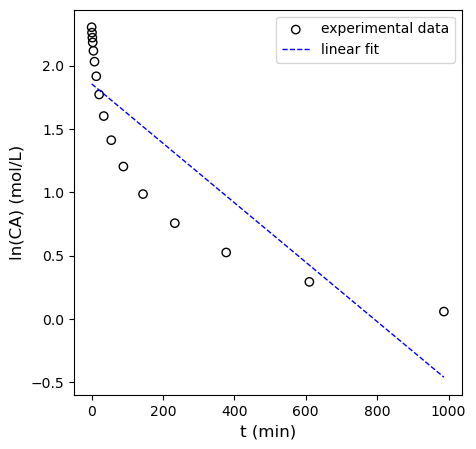

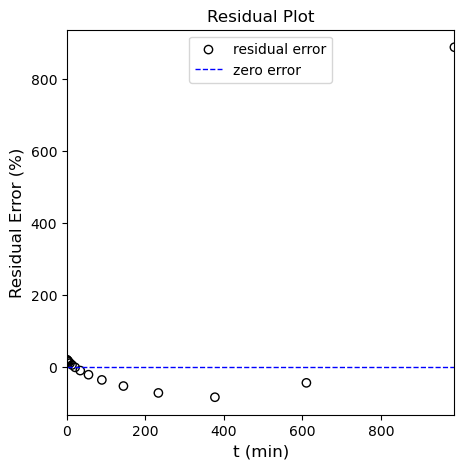

In [99]:
ydata = np.log(CAdata)
xdata = tdata

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
CA0   = np.exp(b)
k     = -m
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'CA0', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, CA0, k]

print(A, '\n')

for label, value in zip(labels, values):
    if (label == 'm') | (label == 'k'):
        print(f'{label:4s} = {value:9.2E} +/- {CIm:9.2E}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2f} +/- {CIb:9.2f}')
    else:
        print(f'{label:4s} = {value:9.2f}')

plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('ln(CA) (mol/L)', fontsize = 12)
# plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
# plt.ylim(floor(min(Y)), ceil(max(Y)))
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
# plt.ylim(-1, 1)
plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
plt.legend(loc = 'upper center')
plt.show()

From any metric we choose, we can see that the fit here isn't very good. All of our quantitative estimates of model error are large, there is clear, systematic deviation between model and prediction, and we find taht $R^2 = 0.75$.

**Second Order Model**

For the second order model, we have:

$$\frac{1}{C_A} = \frac{1}{C_{A0}} + kt$$

We should see linearity here if we plot $\frac{1}{C_A}$ vs $t$.  See below.  Deviation from linearity is clearly observed.

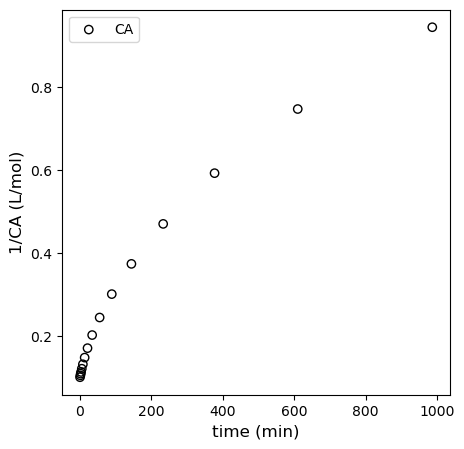

In [102]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tdata, 1/CAdata, edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('1/CA (L/mol)', fontsize = 12)
# plt.xlim(0, 120)
# plt.ylim(0, 12)
plt.legend()
plt.show()
plt.show()

Below, I regress the coefficients for the linearized second order model using polyfit and overlay it with the "linearized" data set.

[0.00089889 0.15897705] 

m    =  8.99E-04 +/-  1.29E-04
b    =      0.16 +/-      0.04
SSE  =      0.06
SST  =      1.00
MSE  =      0.00
RMSE =      0.06
R2   =      0.94
CA0  =      6.29
k    =  8.99E-04 +/-  1.29E-04


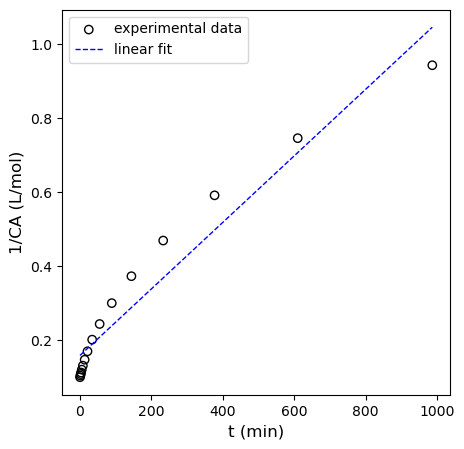

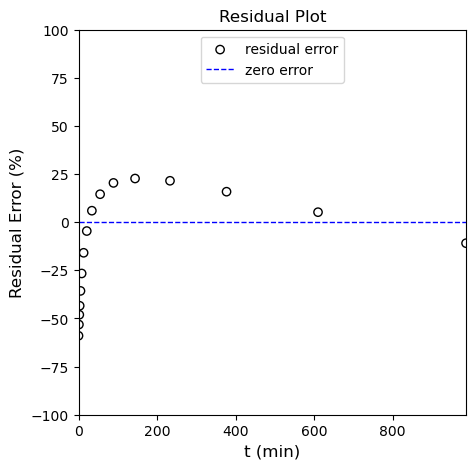

In [104]:
ydata = 1/(CAdata) #discard the last 4 elements; they approach infinity as CA --> 0
xdata = tdata

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
CA0   = 1/b
k     = m
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'CA0', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, CA0, k]

print(A, '\n')

for label, value in zip(labels, values):
    if (label == 'm') | (label == 'k'):
        print(f'{label:4s} = {value:9.2E} +/- {CIm:9.2E}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2f} +/- {CIb:9.2f}')
    else:
        print(f'{label:4s} = {value:9.2f}')

plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('1/CA (L/mol)', fontsize = 12)
# plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
# plt.ylim(floor(min(Y)), ceil(max(Y)))
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.ylim(-100, 100)
plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
plt.legend(loc = 'upper center')
plt.show()

As in the first order case, there is curvature apparent in this second order "linearization." Further, there is clear systematic deviation from the model (non-random scatter); this is a sign that the model does not describe our data very well.

#### Third order linearization

For the third order model, we have:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A0}}^2} + kt$$

We should see linearity here if we plot $\frac{1}{2{C_A}^2}$ vs $t$, and the slope, $\alpha_1$, should give us the rate constant.  This is again a linear model:

$$\alpha_1t^1 + \alpha_0t^0 = \frac{1}{2{C_A}^2}$$

We can put this into the vandermonde form:

$$XA = Y$$

[0.00044674 0.005244  ] 

m    =  4.47E-04 +/-  1.19E-06
b    =      0.01 +/-      0.00
SSE  =      0.00
SST  =      0.23
MSE  =      0.00
RMSE =      0.00
R2   =      1.00
CA0  =    190.69
k    =  4.47E-04 +/-  1.19E-06


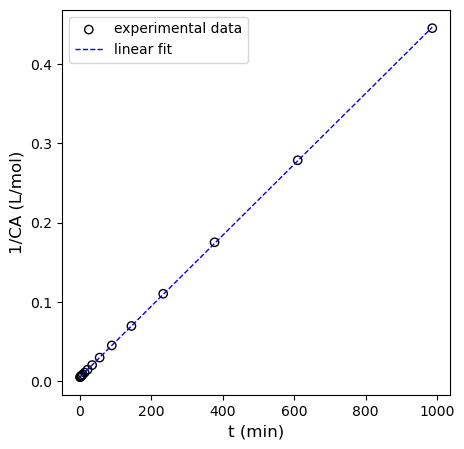

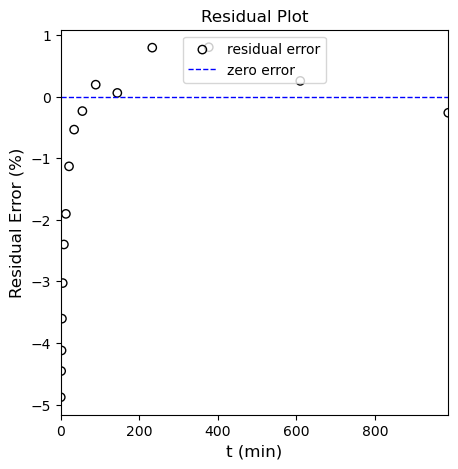

In [115]:
ydata = 1/(2*CAdata**2)
xdata = tdata

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
CA0   = 1/b
k     = m
k3Oa  = k
C3Oa  = CIm

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'CA0', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, CA0, k]

print(A, '\n')

for label, value in zip(labels, values):
    if (label == 'm') | (label == 'k'):
        print(f'{label:4s} = {value:9.2E} +/- {CIm:9.2E}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2f} +/- {CIb:9.2f}')
    else:
        print(f'{label:4s} = {value:9.2f}')

plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('1/CA (L/mol)', fontsize = 12)
# plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
# plt.ylim(floor(min(Y)), ceil(max(Y)))
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
# plt.ylim(-100, 100)
plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
plt.legend(loc = 'upper center')
plt.show()

Finally, a solid linear fit, and we also see a good $R^2$ and small error metrics (SSE, MSE, etc.).

According to the success of this fit, I would conclude that we have a third order reaction and that the rate constant is:

$$k \approx 4.5 \times 10^{-04} \ \mathrm{L^2 \ mol^{-2} \ min^{-1}}$$

### Minimizing Uncertainty by Estimating Fewer Parameters

Clearly, from all of this, we can see that the first order model fits the data best, and our regressed parameters tell us that the rate constant is 0.1 inverse minutes, which is exactly what I used to generate the data.

As a final point, some of you may question why, with our linearized third order model:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A0}}^2} + kt$$

We bothered to regress the y-intercept since we already know the value of $C_{A0}$ for this experiment.  Good observation.  In general, the precision of our estimates by regression decreases as we estimate more parameters.  So, for an optimization where I already know a parameter, $C_{A0}$ in this case, it's probably best if I don't introduce uncertainty by regressing a parameter whose value I'm sure of.  How could you fix it at the known quantity?

Two ways:

1. We use the nonlinear regression approach above, since this gives us complete control over the parameters we estimate.
2. We re-work the linear form of the model and corresponding vandermonde matrix such that we don't estimate the y-intercept.  

Let's look at the latter.  Our original model was

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A0}}^2} + kt$$

And we wrote that as:

$$\alpha_1t^1 + \alpha_0t^0 = \frac{1}{2{C_A}^2}$$

But, since I actually know $C_{A0}$, I could instead do the following linearization.  This would allow me to regress only the rate constant.

$$\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A0}}^2} = kt$$

In this form, I would plot $\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A0}}^2}$ vs. t.  In matrix form, this becomes:

$$\alpha_1t^1 = \frac{1}{2{C_A}^2} - \frac{1}{2{C_{A0}}^2}$$

$$XA = Y$$

Where X is a vandermonde matrix created from tdata; however, we only keep the first order powers of time here (since there is no zero order coefficient in the model).  Y, in this case, is $\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A0}}^2}$, and A is only a single coefficient, namely the slope of the line.  See below for implementation.  We can't use polyfit here, but if we know how to work with the vandermonde matrix, we have a lot of flexibility in regressions.  This is similar to what you can do with the LINEST function in Excel.

[0.00044713] 

m    =  4.47E-04 +/-  1.05E-06
SSE  =      0.00
SST  =      0.23
MSE  =      0.00
RMSE =      0.00
R2   =      1.00
k    =  4.47E-04 +/-  1.05E-06


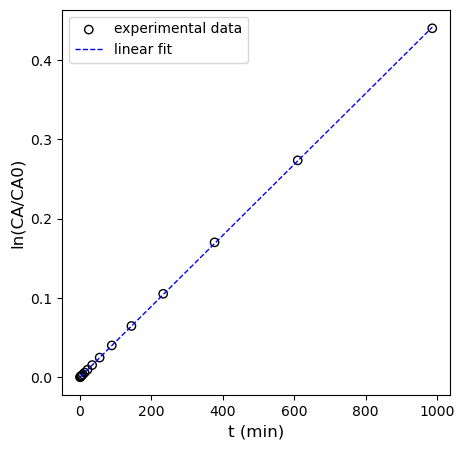

C:\Users\Jesse Bond\AppData\Local\Temp\ipykernel_8636\3604101278.py:48: RuntimeWarning: invalid value encountered in divide
  plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')


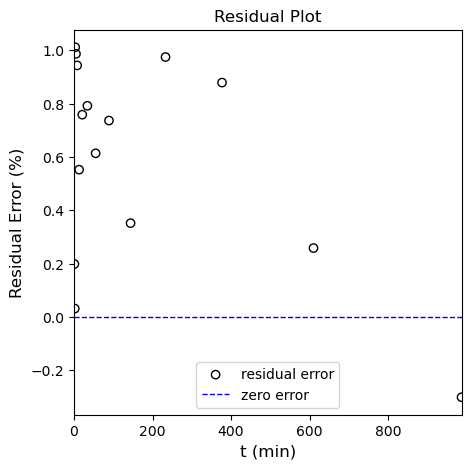

In [113]:
CA0   = 10.0
X     = tdata.reshape(len(tdata), 1)
Y     = 1/(2*CAdata**2) - 1/(2*CA0**2)
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
k     = m
k3Ob  = k
C3Ob  = CIm

labels = ['m', 'SSE', 'SST','MSE','RMSE', 'R2', 'k']
values = [m  ,  SSE ,  SST , MSE , RMSE ,  R2, k]

print(A, '\n')

for label, value in zip(labels, values):
    if (label == 'm') | (label == 'k'):
        print(f'{label:4s} = {value:9.2E} +/- {CIm:9.2E}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2f} +/- {CIb:9.2f}')
    else:
        print(f'{label:4s} = {value:9.2f}')

plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('ln(CA/CA0)', fontsize = 12)
# plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
# plt.ylim(floor(min(Y)), ceil(max(Y)))
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
#plt.ylim(-0.3, 0.3)
plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
plt.legend(loc = 'lower center')
plt.show()

In [114]:
print(f'If we regress the slope and the intercept, we get k = {k3Oa:10.8f} +/- {C3Oa:10.8f}')
print(f'If we regress the slope not the intercept, we get k = {k3Ob:10.8f} +/- {C3Ob:10.8f}')

If we regress the slope and the intercept, we get k = 0.00044674 +/- 0.00000119
If we regress the slope not the intercept, we get k = 0.00044713 +/- 0.00000105
